In [27]:
import pickle
from mapie.regression import MapieRegressor
from sklearn.neural_network import MLPRegressor
import os, sys
sys.path.append(os.path.join(os.getcwd(), '..')) # this is the ml_dadi dir
import plotting
from plotting import plot_accuracy_single
import ml_models
import numpy as np
from mapie.metrics import regression_coverage_score
from matplotlib import pyplot as plt

In [2]:
# Load trained models
mapie_nu1 = pickle.load(open('data/2d_splitmig/mapie_nu1', 'rb'))
mapie_nu2 = pickle.load(open('data/2d_splitmig/mapie_nu2', 'rb'))
mapie_T = pickle.load(open('data/2d_splitmig/mapie_T', 'rb'))
mapie_m = pickle.load(open('data/2d_splitmig/mapie_m', 'rb'))

In [4]:
# Load msprime test data set
seq_l = 1e8
recomb_list = [1e-8, 1e-9, 1e-10, 1e-11]
test_data = []
for recomb in recomb_list:
    test_d = pickle.load(
        open(f'../2d_splitmig/data/msprime/{seq_l:.1e}_{recomb:.1e}', 'rb'))
    test_data.append(test_d)


In [45]:
# unpack test data set
# test_data[i] with i = 0,1,2,3 depending on recombination values
X_test = [test_data[3][params].data.flatten()
          for params in test_data[3]]
y_test = [params for params in test_data[3]]
# separate each param
nu1_test = [params[0] for params in y_test]
nu2_test = [params[1] for params in y_test]
T_test = [params[2] for params in y_test]
m_test = [params[3] for params in y_test]

In [46]:
# implementing MAPIE test
alpha = [0.05, 0.1, 0.2, 0.5, 0.7, 0.85]
# for nu1
nu1_pred, nu1_pis = mapie_nu1.predict(X_test, alpha=alpha)
# for nu2
nu2_pred, nu2_pis = mapie_nu2.predict(X_test, alpha=alpha)
# for T
T_pred, T_pis = mapie_T.predict(X_test, alpha=alpha)
# for m
m_pred, m_pis = mapie_m.predict(X_test, alpha=alpha)

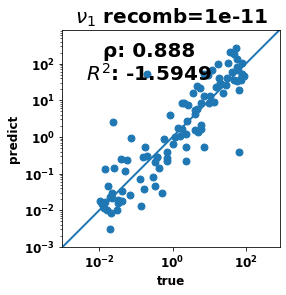

In [47]:
nu1_test_log = [10**p_true for p_true in nu1_test]
nu1_pred_log = [10**p_pred for p_pred in nu1_pred]
r2 = ml_models.r2(nu1_test_log, nu1_pred_log)[0]
rho = ml_models.rho(nu1_test_log, nu1_pred_log)
plot_accuracy_single(nu1_test_log, nu1_pred_log, x_label="true",
                         y_label="predict", size=[6, 2, 20], log=True, r2=r2, rho=rho, title = r'$ν_1$'+ ' '+ 'recomb=1e-11')

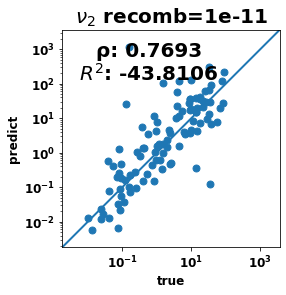

In [48]:
nu2_test_log = [10**p_true for p_true in nu2_test]
nu2_pred_log = [10**p_pred for p_pred in nu2_pred]
r2 = ml_models.r2(nu2_test_log, nu2_pred_log)[0]
rho = ml_models.rho(nu2_test_log, nu2_pred_log)
plot_accuracy_single(nu2_test_log, nu2_pred_log, size=[6, 2, 20], log=True, r2=r2, rho=rho, title = r'$ν_2$'+ ' '+ 'recomb=1e-11')

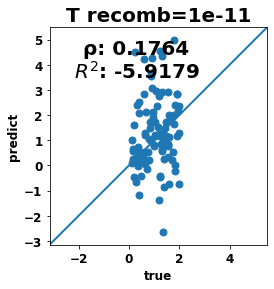

In [49]:
r2 = ml_models.r2(T_test, T_pred)[0]
rho = ml_models.rho(T_test, T_pred)
plot_accuracy_single(T_test, list(T_pred), size=[6, 2, 20], log=False, r2=r2, rho=rho, title = 'T'+ ' '+ 'recomb=1e-11')

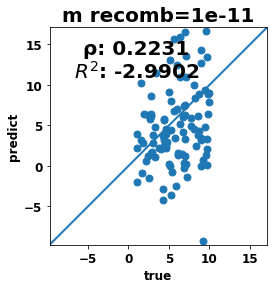

In [50]:
r2 = ml_models.r2(m_test, m_pred)[0]
rho = ml_models.rho(m_test, m_pred)
plot_accuracy_single(m_test, list(m_pred), size=[6, 2, 20], log=False, r2=r2, rho=rho, title='m'+ ' '+ 'recomb=1e-11')

In [52]:
# coverage score by params
nu1_coverage_scores = [
    regression_coverage_score(nu1_test, nu1_pis[:, 0, i], nu1_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]
nu2_coverage_scores = [
    regression_coverage_score(nu2_test, nu2_pis[:, 0, i], nu2_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]
T_coverage_scores = [
    regression_coverage_score(T_test, T_pis[:, 0, i], T_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]
m_coverage_scores = [
    regression_coverage_score(m_test, m_pis[:, 0, i], m_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]

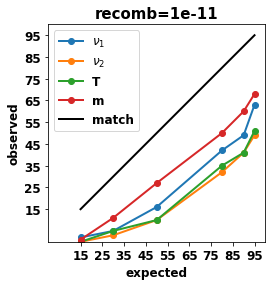

In [53]:
# plot coverage
recomb = recomb_list[3]
expected = [95, 90, 80, 50, 30, 15]
params = [r'$ν_1$', r'$ν_2$', 'T', 'm']

observed = ([s*100 for s in nu1_coverage_scores],
            [s*100 for s in nu2_coverage_scores],
            [s*100 for s in T_coverage_scores],
            [s*100 for s in m_coverage_scores],)

fig = plt.figure()
ax = plt.gca()
ax.set_aspect('equal', 'box')
font = {'weight': 'bold', 'size': 12}
plt.rc('font', **font)

ax.set_title(f'recomb={recomb}', fontsize=15, fontweight='bold')
ax.set_xlabel("expected", fontsize=12, fontweight='bold')
ax.set_ylabel("observed", fontsize=12, fontweight='bold')

for i in range(len(params)):
    ax.plot(expected, observed[i],
            label=params[i], marker='o', linewidth=2)
ax.plot(expected, expected, label='match', linewidth=2, color="black")

plt.xticks(np.arange(min(expected), max(expected)+5, 10))
plt.yticks(np.arange(min(expected), max(expected)+5, 10))
plt.xlim([0, 100])
plt.ylim([0, 100])

ax.legend()